### GPU

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [2]:
# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


### 1. Import Packages

In [3]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score

from tensorflow import keras
import tensorflow as tf

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [4]:
## Global settings
# os.chdir('./Detect_solar_dust/')
data_path = './Detect_solar_dust/'

# IMG_SIZE = 255

### 2. Read Data

In [5]:
dir = sorted(os.listdir(data_path)) 

In [6]:
data = []
bad_img = []
for i in dir:
    class_path = os.path.join(data_path, i)
    file_list = sorted(os.listdir(class_path)) 
    for f in file_list:
        # fpath = os.path.join(class_path,f)
        # img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        # img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        # data.append([np.array(img), np.array(i)])
        try:
            fpath = os.path.join(class_path,f)
            # img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            # img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append([fpath, str(i)])

        except Exception as e:
            print(str(e))
            fpath = os.path.join(class_path,f)
            bad_img.append(fpath)



df = pd.DataFrame(data, columns=['filepaths', 'labels'])

In [7]:
df.labels.value_counts()

Clean    1493
Dusty    1069
Name: labels, dtype: int64

In [8]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# img = mpimg.imread(df.loc[0,'image'])
# imgplot = plt.imshow(img)
# plt.show()

#### Train test split

In [9]:
train_df, other_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])

In [10]:
test_df, valid_df = train_test_split(other_df, train_size=.5, shuffle=True, random_state=123, stratify=other_df['labels'])

#### Plot label

<BarContainer object of 2 artists>

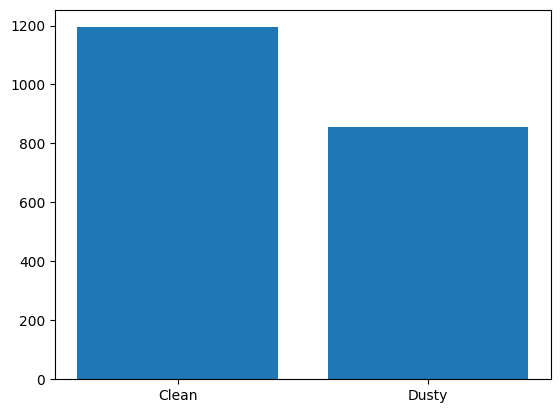

In [11]:
plt.bar(train_df.labels.value_counts().index.astype('string'), train_df.labels.value_counts(), width=0.8, bottom=None, align='center')

which is somekind imbalance

### 3. Preprocessing

#### Balance data 

In [12]:
train_trim = pd.DataFrame(columns=train_df.columns)

In [13]:
train_trim = pd.concat([train_trim, train_df[train_df['labels'] == 'Dusty']])

In [14]:
np.random.seed(42)
keep_n = 855
clean = train_df[train_df['labels'] == 'Clean']
keep_indices = np.random.choice(clean.index, keep_n, replace=False)
keep = clean.loc[keep_indices,:]
drop = clean.drop(keep_indices)
# len(keep)+len(drop)

In [15]:
train_trim = pd.concat([train_trim, keep]).sample(frac=1)
test_df = pd.concat([test_df, drop])

#### Data for training

In [16]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size = 16 #sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

In [17]:
bs=16
img_size=(256,256)
ycol='labels'
train_gen, test_gen, valid_gen, test_steps = make_gens(bs, ycol, train_trim, test_df, valid_df, img_size)

Found 1710 validated image filenames belonging to 2 classes.           for train generator 
Found 257 validated image filenames belonging to 2 classes.            for valid generator 
Found 595 validated image filenames belonging to 2 classes.            for test generator 
test batch size:  16   test steps:  37  number of classes :  2


#### Show the img data

In [18]:
imgs,labels = next(train_gen)

In [19]:
label_map = {v: k for k, v in train_gen.class_indices.items()}

Text(0.5, 1.0, 'Dusty')

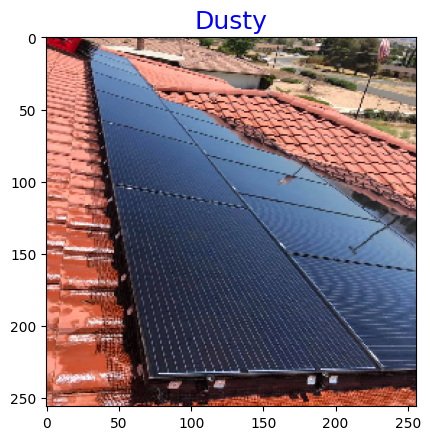

In [20]:
plt.imshow(imgs[1]/255)
plt.title(label_map[1], color='blue', fontsize=18)

### 4. Model

##### settings

In [21]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [124]:
my_callback = [tf.keras.callbacks.EarlyStopping(patience=5, monitor = 'val_accuracy'),
tf.keras.callbacks.TensorBoard(log_dir='.\\logs')]
img_shape=(img_size[0], img_size[1], 3)
adm = Adamax(learning_rate=0.001, decay=1e-6) 
sgd = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

#### ResNet50

In [ ]:
model = Sequential()

model.add(tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max',
    classes=2))
model.add(BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,))
model.add(Dense(128,kernel_regularizer = regularizers.l2(l = 0.02),
                    activity_regularizer=regularizers.l1(0.005),
                    bias_regularizer=regularizers.l1(0.004)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy',F1_score,'AUC'])

In [ ]:
model.summary()

In [68]:
history = model.fit(train_gen,
              batch_size=10,
              epochs=100,
              validation_data=valid_gen,
              callbacks = my_callback,
              shuffle=True)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Writ

c:\Users\Aorus\.conda\envs\tf_2.5_py_3.7\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/repli

c:\Users\Aorus\.conda\envs\tf_2.5_py_3.7\lib\site-packages\PIL\Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


107/107 [==============================] - ETA: 0s - loss: 5.9463 - accuracy: 0.6661 - F1_score: 0.6662 - auc: 0.7195Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/tas

In [69]:
tf.keras.backend.clear_session()

In [70]:
print(model.evaluate(test_gen, verbose=0)[1], model.evaluate(valid_gen, verbose=0)[1],model.evaluate(train_gen, verbose=0)[1])

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

In [ ]:
model.evaluate(test_gen, verbose=0)

In [ ]:
# prediction=model.predict_classes(test_gen)
# m = tf.keras.metrics.BinaryAccuracy()
# m.update_state(test_gen.labels, prediction)
# m.result().numpy()

#### VGG19

In [86]:
model = Sequential()
model.add(tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max',classes=2))
model.add(BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(optimizer = adm, loss = 'categorical_crossentropy', metrics = ['accuracy',F1_score,'AUC'])

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost

In [ ]:
model.summary()

In [87]:
history = model.fit(train_gen,
              batch_size=10,
              epochs=20,
              validation_data=valid_gen,
              callbacks = my_callback,
              shuffle=True)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVari

In [88]:
tf.keras.backend.clear_session()

In [89]:
print(model.evaluate(test_gen, verbose=0)[1], model.evaluate(valid_gen, verbose=0)[1],model.evaluate(train_gen, verbose=0)[1])

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Exe

In [ ]:
model.evaluate(test_gen, verbose=0)

#### Efficient Net

In [125]:
model = Sequential()
model.add(tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max'))
model.add(BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,))
model.add(Dense(128,kernel_regularizer = regularizers.l2(l = 0.02),
                    activity_regularizer=regularizers.l1(0.005),
                    bias_regularizer=regularizers.l1(0.004)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(optimizer = adm, loss = 'categorical_crossentropy', metrics = ['accuracy',F1_score,'AUC'])

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0

In [126]:
import visualkeras

from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from collections import defaultdict
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 12)

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(model, to_file='output.png', color_map = color_map, legend=True, font=font).show() # write and show

In [96]:
history = model.fit(train_gen,
              epochs=50,
              validation_data=valid_gen,
              callbacks = my_callback,
              shuffle=True)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVari

c:\Users\Aorus\.conda\envs\tf_2.5_py_3.7\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in d

c:\Users\Aorus\.conda\envs\tf_2.5_py_3.7\lib\site-packages\PIL\Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


107/107 [==============================] - ETA: 0s - loss: 5.4191 - accuracy: 0.6813 - F1_score: 0.6814 - auc: 0.7407Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/tas

Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


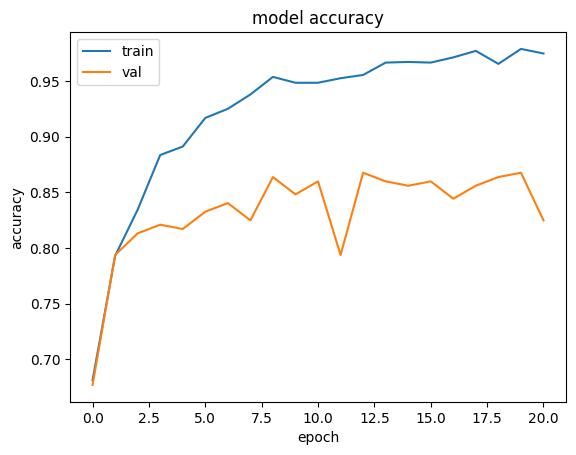

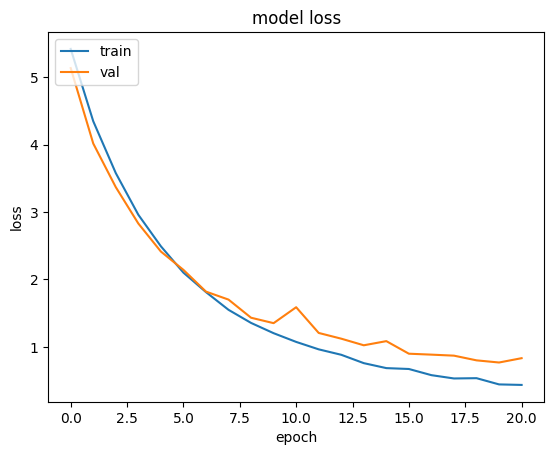

In [97]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [98]:
tf.keras.backend.clear_session()

In [99]:
print(model.evaluate(test_gen, verbose=0)[1], model.evaluate(valid_gen, verbose=0)[1],model.evaluate(train_gen, verbose=0)[1])

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Exe

In [ ]:
# model.evaluate(test_gen)

### Xception

In [59]:
model = Sequential()
model.add(tf.keras.applications.Xception(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max'))

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost

In [60]:
# model.add(Dense(128,kernel_regularizer = regularizers.l2(l = 0.02),
#                     activity_regularizer=regularizers.l1(0.005),
#                     bias_regularizer=regularizers.l1(0.004)))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Activation('relu'))
# model.add(Dropout(0.3))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(optimizer = adm, loss = 'categorical_crossentropy', metrics = ['accuracy'])

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
E

In [ ]:
model.summary()

In [61]:
history = model.fit(train_gen,
              batch_size=10,
              epochs=100,
              validation_data=valid_gen,
              callbacks = my_callback,
              shuffle=True)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSumm

c:\Users\Aorus\.conda\envs\tf_2.5_py_3.7\lib\site-packages\PIL\Image.py:980: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Executing op __inference_train_function_44573 in device /job:localhost/replica:0/task:0/device:GPU:0
107/107 [==============================] - ETA: 0s - loss: 0.5636 - accuracy: 0.7222Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executi

In [62]:
tf.keras.backend.clear_session()

In [63]:
print(model.evaluate(test_gen, verbose=0)[1], model.evaluate(valid_gen, verbose=0)[1],model.evaluate(train_gen, verbose=0)[1])

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

In [ ]:
model.evaluate(test_gen, verbose=0)

### My model

In [117]:
model = Sequential()

model.add(Conv2D(32, (7, 7), padding='same',
                 input_shape=img_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (7, 7), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (7, 7), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(4096))
model.add(Activation('relu'))
# model.add(Dropout(0.2))
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(optimizer = adm, loss = 'categorical_crossentropy', metrics = ['accuracy',F1_score,'AUC'])

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost

In [111]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 256, 256, 32)      4736      
_________________________________________________________________
activation_70 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 256, 256, 32)      50208     
_________________________________________________________________
activation_71 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 256, 256, 32)      50208     
_________________________________________________________________
batch_normalization_33 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
activation_72 (Activation)   (None, 256, 256, 32)     

In [118]:
history = model.fit(train_gen,
              batch_size=10,
              epochs=30,
              validation_data=valid_gen,
              callbacks=my_callback,
              shuffle=True)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DestroyResourceOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSumm

In [119]:
tf.keras.backend.clear_session()

In [120]:
print(model.evaluate(test_gen, verbose=0)[1], model.evaluate(valid_gen, verbose=0)[1],model.evaluate(train_gen, verbose=0)[1])

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

In [ ]:
model.evaluate(test_gen, verbose=0)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir = 'TB', dpi = 900, expand_nested=True)

In [33]:
# !pip install visualkeras

     -------------------------------------- 43.3/43.3 kB 702.7 kB/s eta 0:00:00


In [123]:
import visualkeras
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from collections import defaultdict
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(model, to_file='output.png', color_map = color_map, legend=True, font=font).show() # write and show


### Confusion Matrix

In [121]:
preds=model.predict_classes(test_gen, verbose=1)
cm = confusion_matrix(test_gen.labels, preds)
f1_score(test_gen.labels, preds)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


c:\Users\Aorus\.conda\envs\tf_2.5_py_3.7\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0

0.550632911392405

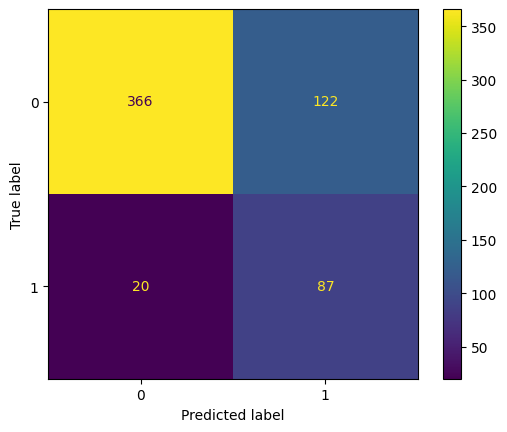

In [122]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [102]:
import collections
collections.Counter(test_gen.labels)

Counter({1: 107, 0: 488})